# Imports

In [103]:
# Standard library imports
import copy
import math
import timeit
from warnings import warn

# Numeric operations
import numpy as np
import pandas as pd

# Image processing and computer vision
import cv2
from PIL import Image, ImageFilter
import skimage
from skimage.feature import blob_log
from skimage import data, exposure, filters, io, measure, morphology, feature, color, util
from skimage.filters import (threshold_mean, threshold_isodata, threshold_minimum,
                             threshold_otsu, threshold_triangle, threshold_li)
from skimage.morphology import skeletonize
from skimage.io import imread
from skimage.measure import label, regionprops
if int(skimage.__version__.split('.')[1]) < 14:
    warn('Your skimage version is: {} but the recommended version is 0.14.0.' 
         'Some features may not work if you do not have the latest version.'.format(skimage.__version__))


# Visualization / Plotting
from matplotlib import pyplot as plt, image as mpimg, patches
from matplotlib.patches import Circle
# Ensuring that matplotlib plots inline for Jupyter notebooks
%matplotlib inline

# Scientific computing and statistics
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.ndimage import convolve, generate_binary_structure
from scipy.ndimage import binary_closing, generate_binary_structure

import tkinter as tk #for opening files with a GUI
from tkinter import filedialog
import os  # Import the os module

# Load Image and Convert to Greyscale

Image shape (#rows, # columns, # color channels): (4480, 4480, 3)
Before conversion to float: data type: uint16, min: 19693, max: 63492
After conversion to float: data type: float64, min: 0.3004959182116426, max: 0.9688258182650492


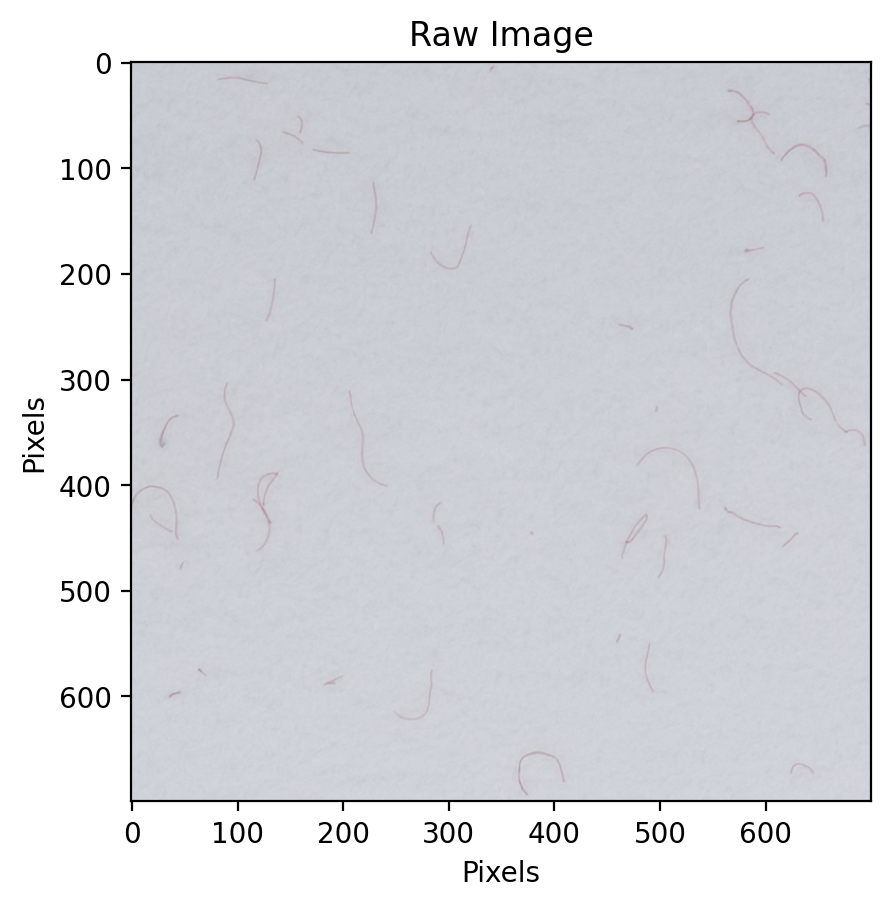

In [105]:
# Define file path and image name

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
root = tk.Tk()
root.withdraw()  # Hide the main window.
# file_path = filedialog.askopenfilename() # use this to open the file from your folder 
file_path = '/Users/jackhegarty/Desktop/0_settle_2.tif' # or use this to open it from the file path 
img_name = os.path.basename(file_path)  # Extract the file name from the full path
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# reading the image/
raw_image = skimage.io.imread(file_path)

# Display image properties
print("Image shape (#rows, # columns, # color channels):", raw_image.shape)
print(f'Before conversion to float: data type: {raw_image.dtype}, min: {raw_image.min()}, max: {raw_image.max()}')

# Convert to float and display the raw image
float_image = skimage.util.img_as_float(raw_image)
print(f'After conversion to float: data type: {float_image.dtype}, min: {float_image.min()}, max: {float_image.max()}')

plt.figure(dpi=200)
plt.imshow(float_image[950:1650,2500:3200], cmap='gray')
plt.title('Raw Image')
plt.xlabel('Pixels') 
plt.ylabel('Pixels')
plt.show()

# Convert to grayscale, invert colors
gray_image = skimage.color.rgb2gray(float_image[1150:1650,2500:3000])


# Remove Image Background

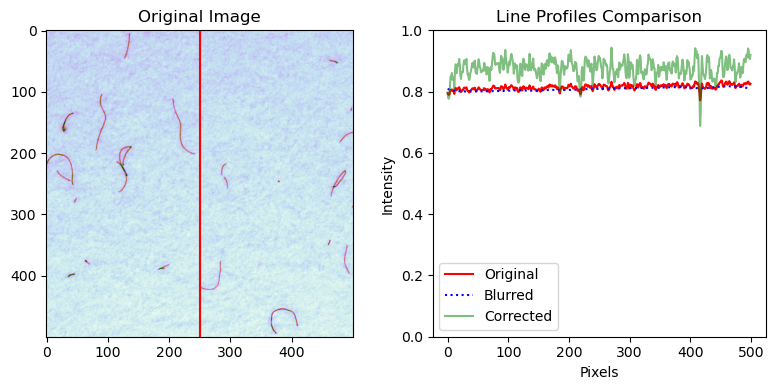

In [106]:
y_pixels, x_pixels = gray_image.shape

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#edit this to change the line profile displayed
section_x=x_pixels//2
#edit this to adjust units based off of the pixel size in your image
calibration_factor=0.01675 # mm/pixel
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Define the spatial dimensions and the reciprocal space parameters
x_edge_length, y_edge_length = x_pixels*calibration_factor, y_pixels*calibration_factor  # dimensions of the image in millimeters
x_sampling = x_pixels / x_edge_length # finds the # of px/mm along x and y dimensions
y_sampling = y_pixels / y_edge_length
x_axis_vec = np.linspace(-x_edge_length / 2, x_edge_length / 2, x_pixels) # Generate linearly spaced vectors representing the physical positions across the image's dimensions
y_axis_vec = np.linspace(-y_edge_length / 2, y_edge_length / 2, y_pixels)
x_mat, y_mat = np.meshgrid(x_axis_vec, y_axis_vec) #Creates matrices of x and y positions for each pixel in the image

# Prepare for Fourier Transform:
u_max = x_sampling / 2 #Determine the maximum frequencies (in reciprocal millimeters) that can be resolved in the Fourier domain given the sampling rates according to the Nyquist-Shannon theorem
v_max = y_sampling / 2
u_axis_vec = np.linspace(-u_max, u_max, x_pixels) #Create vectors of frequency values along each axis in the reciprocal space
v_axis_vec = np.linspace(-v_max, v_max, y_pixels)
u_mat, v_mat = np.meshgrid(u_axis_vec, v_axis_vec) #Generate matrices of frequency positions for the Fourier domain
r = np.sqrt(u_mat**2 + v_mat**2) #Calculate the radial distance from the center of the Fourier domain for each point (used to define the Gaussian filter)

# Gaussian filter in reciprocal space
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit to change the size of the filter
filter_width = 1 # Sets the width of the Gaussian filter in reciprocal space
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
inverse_gauss_filter = 1 - np.exp(-(r * filter_width)**2) #Defines the high pass Gaussian filter in the frequency domain, which attenuates low frequency information
gauss_filter= np.exp(-(r * filter_width)**2)# Gaussian filter, to visualize blurring

# FFT of the image, application of the filter, and IFFT to get the corrected image
fft_image_w_background = np.fft.fftshift(np.fft.fft2(gray_image)) #Computes the 2D Fourier transform of the image and shifts the zero-frequency component to the center
fft_image_corrected = fft_image_w_background * inverse_gauss_filter #Applies the high pass Gaussian filter to the Fourier-transformed image, removing low freq info
image_corrected = np.real(np.fft.ifft2(np.fft.ifftshift(fft_image_corrected))) #Inverse Fourier transform to convert the filtered image back to the spatial domain

# FFT of the image, application of the filter, and IFFT to get the corrected image
fft_image_blurred = fft_image_w_background * gauss_filter #Applies the Gaussian filter to the Fourier-transformed image, blurring it 
image_blurred = np.real(np.fft.ifft2(np.fft.ifftshift(fft_image_blurred))) #Inverse Fourier transform to convert the blurred image back to the spatial domain

# Normalization, [0,1]
corrected_normalized = (image_corrected - image_corrected.min()) / (image_corrected.max() - image_corrected.min())
blurred_normalized = (image_blurred - image_blurred.min()) / (image_blurred.max() - image_blurred.min())

# Calculating line profiles for the blurred and corrected images
line_profile_original = np.squeeze(gray_image[:, section_x])
line_profile_blurred = np.squeeze(image_blurred[:, section_x])
line_profile_corrected = np.squeeze(corrected_normalized[:, section_x])

# Visualization 
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

# Displaying the original and filtered images side by side
axes[0].imshow(gray_image, cmap='cubehelix')
axes[0].set_title('Original Image')
axes[0].axvline(x=section_x, color='r') # Marking the section line

# Plotting the line profiles for the original, blurred, and corrected images 
axes[1].plot(line_profile_original, color='r', label='Original')
axes[1].plot(line_profile_blurred, color='b', label='Blurred', linestyle='dotted')
axes[1].plot(line_profile_corrected, color='g', label='Corrected', alpha=0.5)
axes[1].set_title('Line Profiles Comparison')
axes[1].set_xlabel('Pixels')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_ylim([0, 1])

fig.tight_layout()
plt.show()

# Circular Crop and Renormalization 

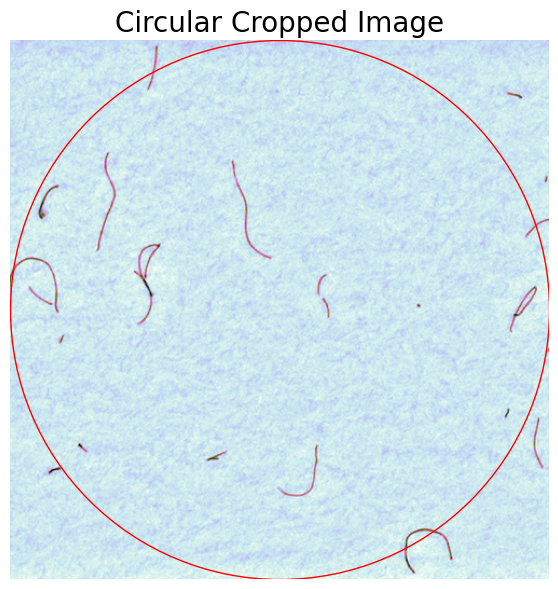

In [107]:
# Crop the image with a border to center the filter paper, use below figure to ensure ideal cropping.
# Can skip this step if entire circular filter paper is not imaged
height, width = corrected_normalized.shape

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit to adjust the circular crop
border = 000 # a border of this many pixels is removed from the image
right_shift = 0 # the image can then be shifted (right, left, up, down)to center it
down_shift = 0 #the image shift cannot exceed to border
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

border_cropped_image = corrected_normalized[border-down_shift:height-border-down_shift, border-right_shift:width-border-right_shift]

# Create a circular mask
cropped_height, cropped_width = border_cropped_image.shape
y, x = np.ogrid[:cropped_height, :cropped_width]
center_y, center_x = cropped_height / 2, cropped_width / 2
radius = cropped_height / 2
distance_from_center = (y - center_y)**2 + (x - center_x)**2
circular_mask = distance_from_center > radius**2

# Apply the circular mask to select pixels within the circle
pixels_inside_circle = border_cropped_image[circular_mask]

# Calculate the median pixel value of the pixels inside the circle
median_pixel_value = np.median(pixels_inside_circle)

# Apply the circular mask to the cropped image
circular_cropped_image = border_cropped_image.copy()
circular_cropped_image[circular_mask] = median_pixel_value  # Set pixels outside the circle to 0 (black)

# Display the circular cropped image
fig, axis = plt.subplots(figsize=(7, 7))
axis.imshow(border_cropped_image, cmap='cubehelix')
axis.set_title('Circular Cropped Image', fontsize=20)
axis.axis('off')  # Optionally, turn off the axis
# Draw the circle with a red outline
circle = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=1)
axis.add_patch(circle)
plt.show()


# Invert Image

In [108]:
# to skip circular cropping
inverted_circular_cropped_image = 1 - circular_cropped_image  # Inverting the grayscale values 

# Binarization and Gap Closing

Threshold value: 0.33480625351450805


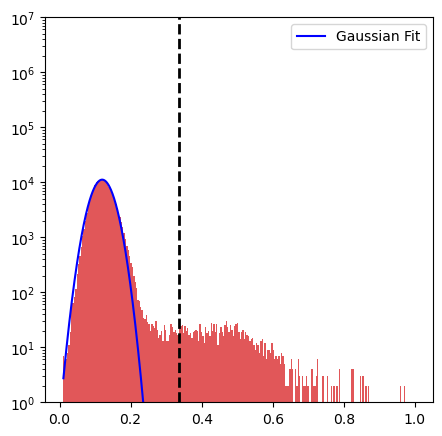

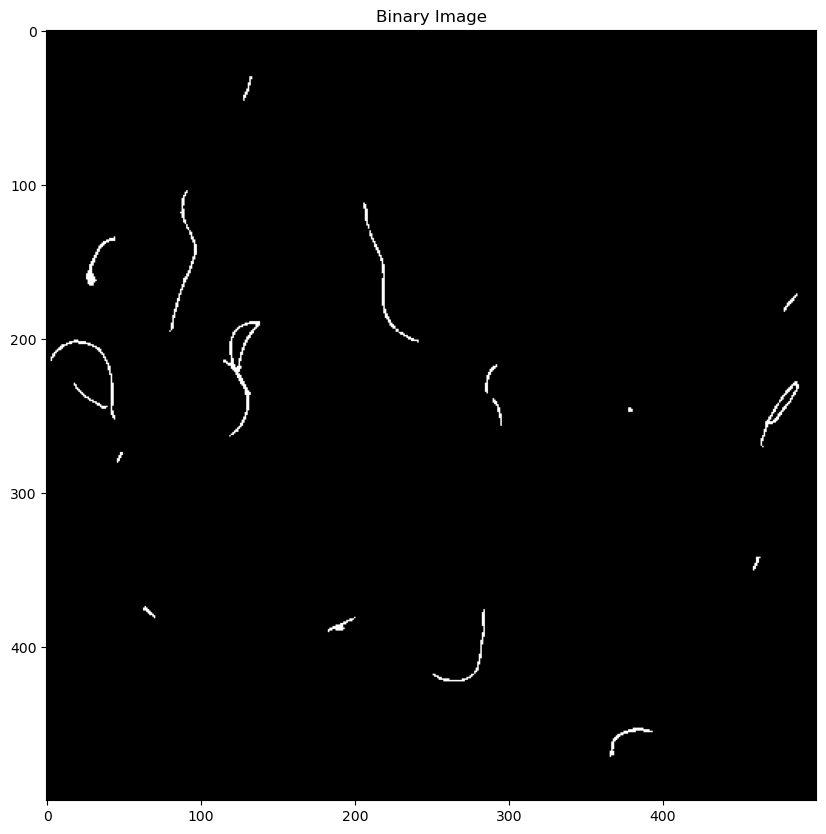

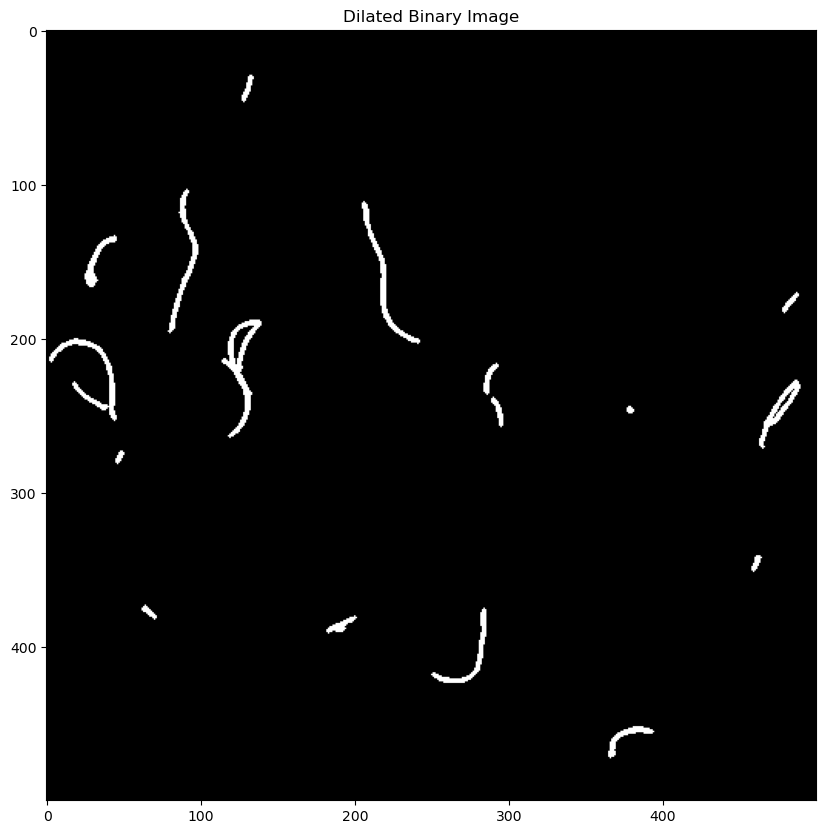

In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Function for Gaussian
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation**2))

# Use only the pixels inside the circular mask for histogram and Gaussian fit
data_inside_circle = inverted_circular_cropped_image[~circular_mask]

# Histogram and Gaussian Fit with Logarithmic Scale
fig1, axis = plt.subplots(figsize=(5, 5))
n, bins, patches = plt.hist(data_inside_circle.ravel(), 255, color='#e15759', edgecolor='none')
plt.yscale('log')
plt.ylim(1, 10**7)  # Setting y-axis limits

# Calculate a generic initial guess for standard deviation
std_dev_guess = (max(data_inside_circle) - min(data_inside_circle)) / len(bins)

# Identifying the first large peak
bin_centers = 0.5 * (bins[1:] + bins[:-1])
max_bin = np.argmax(n)  # index of first large peak
popt, _ = curve_fit(gaussian, bin_centers, n, p0=[bin_centers[max_bin], n[max_bin], std_dev_guess])

# Plotting the Gaussian fit on Logarithmic Scale Histogram
x_interval_for_fit = np.linspace(bin_centers[0], bin_centers[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian Fit', color='blue')
plt.legend()

# Calculating new threshold based on Gaussian standard deviation
gaussian_std_dev = popt[2]

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit the multiplier to adjust the threshold offset
thresh = np.median(data_inside_circle) + 8 * gaussian_std_dev
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

print("Threshold value:", thresh)
plt.axvline(x=thresh, color='black', linewidth=2, linestyle='--')  # add the threshold to the plot

# Plotting the thresholded image
fig2, axis = plt.subplots(figsize=(10, 10))
binary = inverted_circular_cropped_image.copy() 
binary[inverted_circular_cropped_image < thresh] = 0
binary[inverted_circular_cropped_image >= thresh] = 255
im_handle = axis.imshow(binary, cmap='gray')
axis.set_title('Binary Image');


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#edit this to adjust the amount of dilation 
dilation_amount = 3 # should be a positive odd integer, no dilation occur when dilation_amount = 1
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Use this to make a circular kernel
def create_circular_kernel(diameter, dtype=np.uint8):
    radius = diameter // 2
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    return mask.astype(dtype)
kernel = create_circular_kernel(dilation_amount)

# # Use this to make a square kernel for dilation instead of a circular one
# kernel = np.ones((dilation_amount, dilation_amount), np.uint8)  # Adjust the size based on the distance to be merged

# Apply dilation
dilated_binary = cv2.dilate(binary, kernel, iterations=1)

# Plot the dilated binary image
fig, axis = plt.subplots(figsize=(10, 10))
im_handle = axis.imshow(dilated_binary, cmap='gray')
axis.set_title('Dilated Binary Image')
plt.show()

# Save the thresholded binary image as a PNG file
# plt.imsave('closed_thresholded_image.png', closed_binary, cmap='gray')

# Skeletonization 

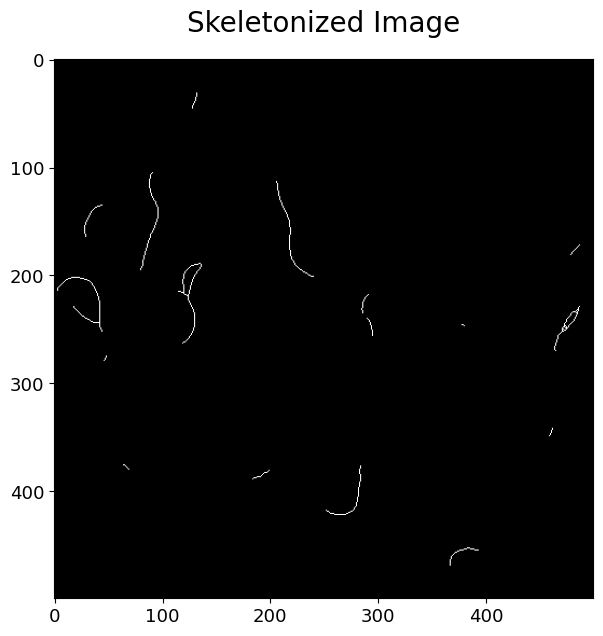

In [111]:
skeleton = skeletonize(dilated_binary)
# Plotting the image
fig, axis = plt.subplots(figsize=(7, 7))
im_handle = axis.imshow(skeleton, cmap='gray')
axis.set_title('Skeletonized Image', pad=20,fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

# Junction Detection

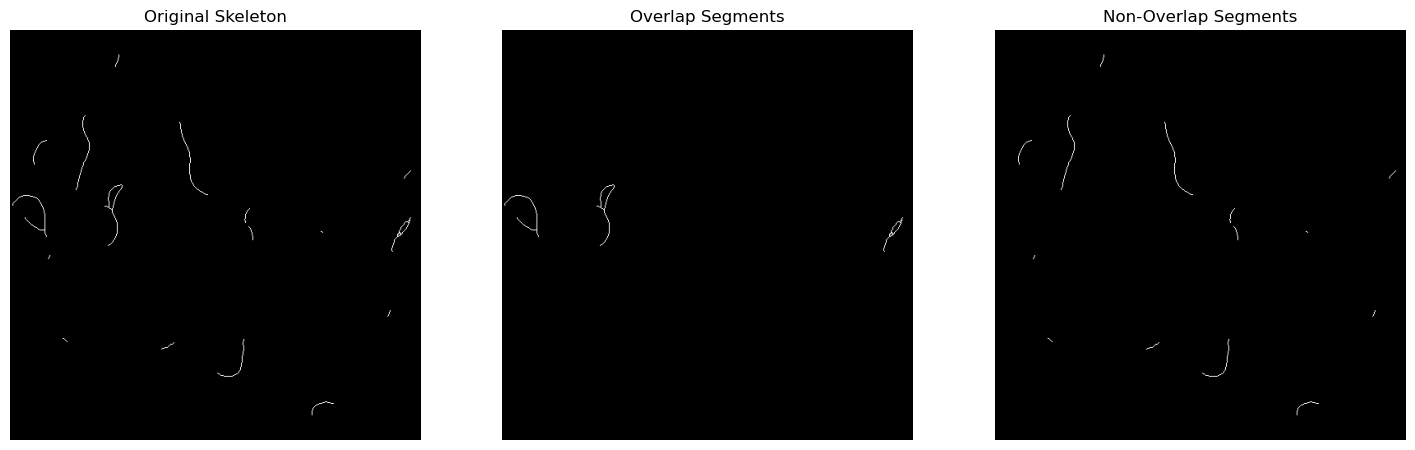

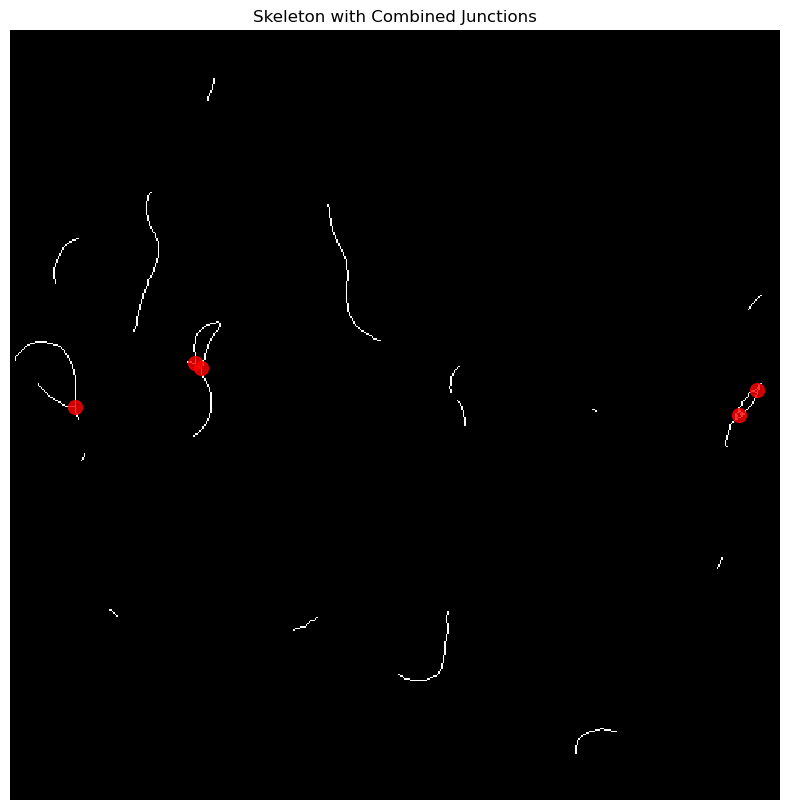

In [113]:

def find_junctions(skeleton):
    # Using a convolution-based approach to identify junctions
    connectivity_kernel = generate_binary_structure(2, 2)
    neighbors = convolve(skeleton.astype(int), connectivity_kernel, mode='constant', cval=0)
    junctions = (neighbors > 3) & skeleton
    labeled_junctions = label(junctions)
    num_junctions = np.max(labeled_junctions)  # The maximum label number is the count of distinct junctions
    # print(f"Number of junctions: {num_junctions}") #uncomment this if you want to see how many junctions there are 
    # Apply morphological closing to combine nearby junctions
    closed_junctions = binary_closing(junctions, structure=generate_binary_structure(2, 1))
    return closed_junctions


def plot_junctions(skeleton, junctions):
    # Label the junctions to identify individual junction regions
    labeled_junctions = label(junctions)
    props = regionprops(labeled_junctions)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(skeleton, cmap='gray', interpolation='none')
    # Plot the centroid of each junction area
    for prop in props:
        plt.scatter(prop.centroid[1], prop.centroid[0], color='r', s=100, alpha=0.8)
    plt.title('Skeleton with Combined Junctions')
    plt.axis('off')
    plt.show()

def analyze_and_segment_overlaps(skeleton):
    labeled_skeleton = label(skeleton, connectivity=2)
    junctions = find_junctions(skeleton)
    
    # Identify components that include junctions
    junction_labels = np.unique(labeled_skeleton[junctions])
    
    # Exclude the background label, which is typically '0'
    junction_labels = junction_labels[junction_labels != 0]
    
    # Filter skeleton to only include components with junctions
    overlap_skeleton = np.isin(labeled_skeleton, junction_labels).astype(int)
    
    # Create a binary image of components without junctions
    all_labels = np.unique(labeled_skeleton)
    non_junction_labels = np.setdiff1d(all_labels, junction_labels, assume_unique=True)
    non_junction_labels = non_junction_labels[non_junction_labels != 0]  # Ensure background is excluded if necessary
    binary_no_overlaps = np.isin(labeled_skeleton, non_junction_labels).astype(int)

    # Visualization to compare the segments
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(skeleton, cmap='gray')
    plt.title('Original Skeleton')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(overlap_skeleton, cmap='gray')
    plt.title('Overlap Segments')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(binary_no_overlaps, cmap='gray')
    plt.title('Non-Overlap Segments')
    plt.axis('off')
    
    plt.show()
    
    return overlap_skeleton, junction_labels, binary_no_overlaps

def plot_contours_with_junctions(skeleton, junction_labels):
    labeled_skeleton = label(skeleton, connectivity=2)  # Ensure the skeleton is labeled

    if len(junction_labels) > 0:
        # Setup the subplot array
        fig, axes = plt.subplots(1, len(junction_labels), figsize=(15, 3))
        if len(junction_labels) == 1:
            axes = [axes]  # Ensure axes is always a list, even for one subplot

        for ax, j_label in zip(axes, junction_labels):
            # Extract and plot each contour containing junctions
            contour_mask = (labeled_skeleton == j_label)
            region = regionprops(contour_mask.astype(int))[0]  # Get the region properties
            minr, minc, maxr, maxc = region.bbox  # Get the bounding box coordinates

            # Crop the contour mask to the bounding box with a small margin
            margin = 5  # You can adjust the margin size as needed
            minr = max(minr - margin, 0)
            minc = max(minc - margin, 0)
            maxr = min(maxr + margin, contour_mask.shape[0])
            maxc = min(maxc + margin, contour_mask.shape[1])

            cropped_contour = contour_mask[minr:maxr, minc:maxc]
            ax.imshow(cropped_contour, cmap='gray')
            ax.set_title(f'Contour with Junction #{j_label}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No junction labels found to plot.")




# Find and plot combined junctions
junctions = find_junctions(skeleton)

# Segment overlapping fibers and get labels of contours containing junctions
overlap_segments, junction_labels, binary_no_overlaps = analyze_and_segment_overlaps(skeleton)

# Plot each contour with junctions individually
# plot_contours_with_junctions(skeleton, junction_labels)

# Optionally, plot all junctions together
plot_junctions(skeleton, junctions)

# Characterize Overlapping Junctions 

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.color import gray2rgb
from ipywidgets import Button, HBox, VBox, Output, IntText, Label
from IPython.display import display, Javascript


import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.color import gray2rgb
from ipywidgets import Button, HBox, VBox, Output, IntText, Label

import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.color import gray2rgb
from ipywidgets import Button, HBox, VBox, Output, IntText, Label

# Global definition of total_count_label for demo purposes
total_count_label = Label()  # Initialize somewhere in your setup

def get_total_fiber_count():
    # Extract just the numeric part of the label's value
    total_fibers = int(total_count_label.value.split(': ')[1])
    return total_fibers

def interactive_plot_contours_with_junctions(skeleton, circular_cropped_image, junction_labels):
    global total_count_label  # Ensure we are using the global instance
    labeled_skeleton = label(skeleton, connectivity=2)  # Label the skeleton

    images = []  # List to hold cropped images from the circular_cropped_image image for interactive viewing
    titles = []  # Titles for each image
    fiber_counts = {}  # Dictionary to store fiber counts for each image

    alpha = 0.2  # Transparency level of the red overlay
    
    if junction_labels.size == 0:  # This check avoids the ambiguity warning
        print("No junctions found in the skeleton.")
        return None  # Exit the function or handle the lack of junctions appropriately

    for j_label in junction_labels:
        contour_mask = (labeled_skeleton == j_label)
        region = regionprops(contour_mask.astype(int))[0]  # Get the region properties
        minr, minc, maxr, maxc = region.bbox  # Get the bounding box coordinates

        margin = 20  # Margin size
        minr = max(minr - margin, 0)
        minc = max(minc - margin, 0)
        maxr = min(maxr + margin, contour_mask.shape[0])
        maxc = min(maxc + margin, contour_mask.shape[1])

        # Crop the corresponding region from the circular_cropped_image image
        cropped_image = circular_cropped_image[minr:maxr, minc:maxc]
        cropped_skeleton = contour_mask[minr:maxr, minc:maxc]

        # Ensure the image is in the correct format and range
        if np.max(cropped_image) > 1:
            cropped_image = cropped_image / 255.0  # Normalize to 0-1 if in 0-255 range

        # Convert grayscale to RGB
        overlay_image = gray2rgb(cropped_image)
        red_overlay = np.zeros_like(overlay_image)
        red_overlay[cropped_skeleton, 1] = 1  # Set only the red channel

        # Blend the overlay with the grayscale image
        overlay_image = overlay_image + alpha * red_overlay
        overlay_image = np.clip(overlay_image, 0, 1)  # Ensure values are within the [0,1] range

        images.append(overlay_image)  # Store the overlay image
        titles.append(f'Contour with Junction #{j_label}')  # Store the title
        fiber_counts[j_label] = 0  # Initialize fiber count

    current_image = 0  # Index of the currently displayed image

    output = Output()
    count_input = IntText(value=0, description='Fiber Count:', disabled=False)
    total_count_label = Label()  # Label for displaying the total count

    def on_next_clicked(b):
        nonlocal current_image
        update_fiber_count()
        if current_image < len(images) - 1:
            current_image += 1
        display_image()
        
    def on_two_fibers_clicked(b):
        nonlocal current_image
        # Check if already counted for the last image to prevent multiple counts
        if current_image == len(images) - 1 and count_input.value == 2:
            return  # Exit if already updated for last image
    
        update_total_count(2)  # Add 2 to the total count
        fiber_counts[junction_labels[current_image]] = 2
        count_input.value = 2  # Update the count input to reflect the addition of 2 fibers
        
        if current_image < len(images) - 1:
            on_next_clicked(b)  # Use next button's logic to move to the next image
        else:
            display_image()  # Refresh the display to update any changes
            
    def on_prev_clicked(b):
        nonlocal current_image
        update_fiber_count()
        if current_image > 0:
            current_image -= 1
        display_image()

    def update_fiber_count():
        # Capture the current input value and update total if it's different from the stored count
        new_count = count_input.value
        old_count = fiber_counts[junction_labels[current_image]]
        if new_count != old_count:
            update_total_count(new_count - old_count)
            fiber_counts[junction_labels[current_image]] = new_count

    def update_total_count(delta):
        # Update the total fiber count
        current_total = int(total_count_label.value.split(': ')[1]) if total_count_label.value else 0
        total_count_label.value = f"Total Fibers Counted: {current_total + delta}"

    def display_image():
        with output:
            output.clear_output(wait=True)
            plt.figure(figsize=(6,6))
            plt.imshow(images[current_image])
            plt.title(titles[current_image])
            plt.axis('off')
            plt.show()
        # Update count input to current fiber count
        count_input.value = fiber_counts[junction_labels[current_image]]
        

    next_button = Button(description="Next")
    prev_button = Button(description="Previous")
    two_fibers_button = Button(description="2 fibers")  # New button for adding 2 fibers and moving to next
    next_button.on_click(on_next_clicked)
    prev_button.on_click(on_prev_clicked)
    two_fibers_button.on_click(on_two_fibers_clicked)  # Bind the new button action

    display_image()  # Display the first image initially
    total_count_label.value = "Total Overlapping Fibers Counted: 0"  # Initialize total count label

    # Organize the buttons, including the new "2 fibers" button
    buttons = HBox([prev_button, two_fibers_button, next_button])
    controls = VBox([buttons, count_input, total_count_label, output])
    return controls

# To use this:
# Assuming you have the skeleton, circular_cropped_image, and junction_labels defined and computed
display(interactive_plot_contours_with_junctions(skeleton, circular_cropped_image, junction_labels))

## Count Contours and Determine their Area

Number of large contours found: 12


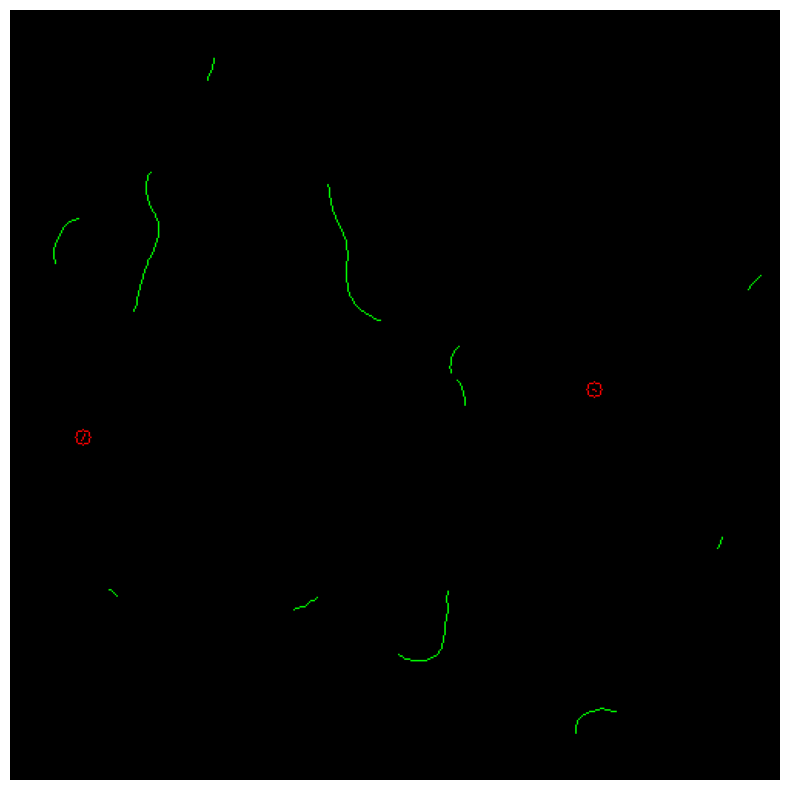

In [115]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# This can be run on the image before or after overlapping instances are removed 

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# binary_for_stats = np.uint8(skeleton) #use this to analyze the entire image including instances with overlaps 
binary_for_stats = np.uint8(binary_no_overlaps) #use this to analyze the image without overlaps 
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Apply connectedComponentsWithStats
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_for_stats, connectivity=8)

# Define the threshold for large contours
large_contour_threshold = 5

# Create an empty color image (BGR)
contour_image = np.zeros((binary_for_stats.shape[0], binary_for_stats.shape[1], 3), dtype=np.uint8)

# Lists to store contour data
contour_areas = []
contour_lengths = []  # List to store contour lengths
large_contours_count = 0

# Color the contours and draw circles for small contours
for i in range(1, num_labels):  # Start from 1 to ignore the background label
    area = stats[i, cv2.CC_STAT_AREA]
    contour_areas.append(area)  # Append the area directly as a number
    
    # Extract binary image for current contour
    component_mask = (labels == i).astype(np.uint8) * 255

    # Find contours for the individual connected component
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
   
    if contours:
        contour = contours[0]
        # closed = np.array_equal(contour[0], contour[-1])  # Check if the first and last points are the same
        length = cv2.arcLength(contour, True)/2
        # if area > 1.1 * length:  # Check if length is greater than 1.2 times the area
        #     length *= 2  # If so, divide the length by 2
        contour_lengths.append(length)
    else:
        contour_lengths.append(0)  # No contour found, unlikely case

    
    # Increment large contours count
    if area > large_contour_threshold:
        large_contours_count += 1

    # Choose color: green for large contours, red for small contours
    color = (0, 255, 0) if area > large_contour_threshold else (0, 0, 255)

    # Color the pixels belonging to each contour
    contour_image[labels == i] = color
    
    # # Label each contour with index, area, and length, uncomment to add to plot
    # cx, cy = int(centroids[i][0]), int(centroids[i][1])
    # label_text = f"A={area}, L={length:.1f}"
    # cv2.putText(contour_image, label_text, (cx-20, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    
    # Draw a red circle around small contours
    if area <= large_contour_threshold:
        center = (int(centroids[i][0]), int(centroids[i][1]))
        cv2.circle(contour_image, center, 5, (0, 0, 255), 1)
        
# Print the number of large contours
print("Number of large contours found:", large_contours_count)

# code for saving image data
# ================================================================
# # Define the folder path where the file will be saved
# folder_path = '/your/folder/path/'

# # Extract the base name without extension and add '.xlsx' extension for the Excel file
# excel_file_name = img_name.split('.')[0] + '.xlsx'
# excel_file_path = folder_path + excel_file_name

# # Data for DataFrame
# data = {
#     "Total Number of Contours": [num_labels - 1] * len(contour_areas),
#     "Number of Large Contours": [large_contours_count] * len(contour_areas),
#     "Area of Contour": contour_areas
# }

# # Create DataFrame and save to Excel
# df = pd.DataFrame(data)
# df.to_excel(excel_file_path, index=False)
# ================================================================

# Plotting the image  
plt.figure(figsize=(10, 10)) 
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off the axis

# code for saving the image
# ================================================================
# # Define the filename for the plot
# plot_file_name = img_name.split('.')[0] + '_contours_skel1.png'
# plot_file_path = folder_path + plot_file_name

# # Save the plot with high DPI
# high_dpi = 600  # You can adjust this value as needed
# plt.savefig(plot_file_path, bbox_inches='tight', pad_inches=0, dpi=high_dpi)
# ================================================================

# Now display the plot
plt.show()

# Blob Detection

Number of blobs found: 18


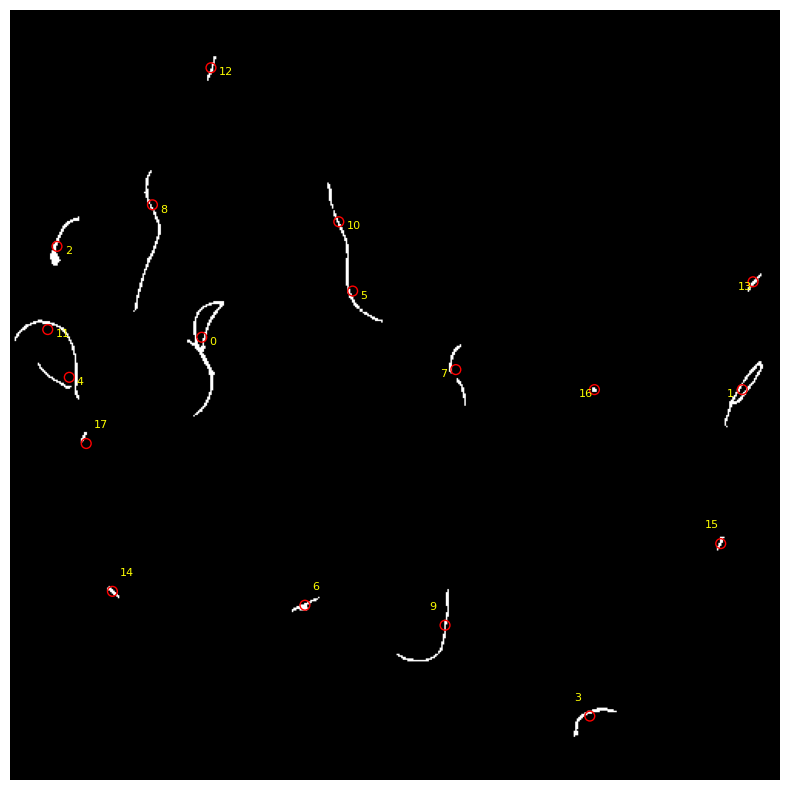

In [116]:
# Blob detection is not optimal for fibrous microplastics but is included here for comparison
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit parameters as necessary
blobs = blob_log(binary, min_sigma=16, max_sigma=25, num_sigma=1, threshold=0.005)
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Print the number of blobs found
num_blobs = len(blobs)  # Number of blobs
print("Number of blobs found:", num_blobs)

# Plotting blobs
plt.figure(figsize=(10, 10))
plt.imshow(binary, cmap='gray')

# Extract coordinates and radius of blobs and draw and label each blob
for i, (xi, yi) in enumerate(zip(blobs[:, 1], blobs[:, 0])):
    plt.scatter(xi, yi, marker='o', s=50, edgecolor='red', facecolor='none')

    # Determine the offsets based on the blob's position
    text_offset_x = 5 if xi < binary.shape[1] / 2 else -10
    text_offset_y = 5 if yi < binary.shape[0] / 2 else -10

    # Apply the offsets and ensure text stays within the image boundaries
    text_x = max(0, min(xi + text_offset_x, binary.shape[1] - 1))
    text_y = max(0, min(yi + text_offset_y, binary.shape[0] - 1))

    plt.text(text_x, text_y, str(i), color='yellow', fontsize=8)

plt.axis('off')  # Turn off the axis

# code for saving the image
# ================================================================
# # Define the filename for the plot
# plot_file_name = img_name.split('.')[0] + '_blobs.png'
# plot_file_path = folder_path + plot_file_name

# # Save the plot with high DPI
# high_dpi = 600  # You can adjust this value as needed
# plt.savefig(plot_file_path, bbox_inches='tight', pad_inches=0, dpi=high_dpi)
# ================================================================

# # Now display the plot
plt.show()